# 1. Setup Spark Context

In [1]:
# Loading required libraries

from os import listdir
from os.path import isfile, join
import boto3
import pandas as pd
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType

In [2]:
# Initialize the spark environment (takes ~ 1min)
import pyspark
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)

In [3]:
sc

<SparkContext master=local appName=odl>

In [4]:
sqlc

# 2. Convert Data to Parquet Format

### * Method 1 - locally from sagemaker

In [5]:
dataPath = "winedata.csv"
df = sqlc.read.format("csv")\
  .option("header","true")\
  .option("inferSchema", "true")\
  .load(dataPath)

In [6]:
df.printSchema()

root
 |-- Alcohol: integer (nullable = true)
 |-- MalicAcid: double (nullable = true)
 |-- Ash: double (nullable = true)
 |-- AlcalinityOfAsh: double (nullable = true)
 |-- Magnesium: double (nullable = true)
 |-- TotalPhenols: integer (nullable = true)
 |-- Flavanoids: double (nullable = true)
 |-- NonFlavanoidPhenols: double (nullable = true)
 |-- Proanthocyanins: double (nullable = true)
 |-- ColorIntensity: double (nullable = true)
 |-- Hue: double (nullable = true)
 |-- ODdilutedWines: double (nullable = true)
 |-- Proline: double (nullable = true)



In [7]:
parquetPath = '/home/ec2-user/SageMaker/kd2hr/test-parquet'
df.write.parquet(parquetPath)

In [8]:
# Read from parquet

data = sqlc.read.parquet(parquetPath)
display(data)

DataFrame[Alcohol: int, MalicAcid: double, Ash: double, AlcalinityOfAsh: double, Magnesium: double, TotalPhenols: int, Flavanoids: double, NonFlavanoidPhenols: double, Proanthocyanins: double, ColorIntensity: double, Hue: double, ODdilutedWines: double, Proline: double]

### * Method 2 - Read from S3 bucket

In [9]:
# Read into spark df from s3
role = get_execution_role()
bucket='odl-spark19spds6003-001/kd2hr'
data_key = 'winedata.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

In [10]:
df = sqlc.createDataFrame(pd.read_csv(data_location))

In [11]:
df.printSchema()

root
 |-- Alcohol: long (nullable = true)
 |-- MalicAcid: double (nullable = true)
 |-- Ash: double (nullable = true)
 |-- AlcalinityOfAsh: double (nullable = true)
 |-- Magnesium: double (nullable = true)
 |-- TotalPhenols: long (nullable = true)
 |-- Flavanoids: double (nullable = true)
 |-- NonFlavanoidPhenols: double (nullable = true)
 |-- Proanthocyanins: double (nullable = true)
 |-- ColorIntensity: double (nullable = true)
 |-- Hue: double (nullable = true)
 |-- ODdilutedWines: double (nullable = true)
 |-- Proline: double (nullable = true)



In [12]:
parquetPath = '/home/ec2-user/SageMaker/kd2hr/tmp-pqt'
df.write.parquet(parquetPath)

In [13]:
# Read from parquet

data = sqlc.read.parquet(parquetPath)
display(data)

DataFrame[Alcohol: bigint, MalicAcid: double, Ash: double, AlcalinityOfAsh: double, Magnesium: double, TotalPhenols: bigint, Flavanoids: double, NonFlavanoidPhenols: double, Proanthocyanins: double, ColorIntensity: double, Hue: double, ODdilutedWines: double, Proline: double]

# 3. MLlib based Analysis

In [14]:
print("Pearson's r(ColorIntensity,MalicAcid) = {}".format(df.corr("ColorIntensity", "MalicAcid")))
print("Pearson's r(ColorIntensity,Proline) = {}".format(df.corr("ColorIntensity", "Proline")))
print("Pearson's r(ColorIntensity,TotalPhenols) = {}".format(df.corr("ColorIntensity", "TotalPhenols")))
print("Pearson's r(Proanthocyanins,ODdilutedWines) = {}".format(df.corr("Proanthocyanins", "ODdilutedWines")))

Pearson's r(ColorIntensity,MalicAcid) = 0.13669791176947926
Pearson's r(ColorIntensity,Proline) = 0.519067095682523
Pearson's r(ColorIntensity,TotalPhenols) = 0.23644060977750714
Pearson's r(Proanthocyanins,ODdilutedWines) = -0.2626396311498339


In [15]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier as RF
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler, SQLTransformer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np
import functools
from pyspark.ml.feature import OneHotEncoder

In [16]:
# prepare labeled sets

cols_now = ['MalicAcid',
            'Ash',
            'AlcalinityOfAsh',
            'Magnesium',
            'TotalPhenols',
            'Flavanoids',
            'NonFlavanoidPhenols',
            'Proanthocyanins',
            'ColorIntensity',
            'Hue',
            'ODdilutedWines',
            'Proline']

assembler_features = VectorAssembler(inputCols=cols_now, outputCol='features')
labelIndexer = StringIndexer(inputCol='Alcohol', outputCol="label")
tmp = [assembler_features, labelIndexer]
pipeline = Pipeline(stages=tmp)

In [17]:
# create train/test sets

allData = pipeline.fit(df).transform(df)
allData.cache()
trainingData, testData = allData.randomSplit([0.8,0.2], seed=0) # need to ensure same split for each time
print("Distribution of Alcohol in trainingData is: ", trainingData.groupBy("label").count().take(3))

Distribution of Alcohol in trainingData is:  [Row(label=0.0, count=57), Row(label=1.0, count=46), Row(label=2.0, count=41)]


In [18]:
# Training data set

rf = RF(labelCol='label', featuresCol='features',numTrees=200)
fit = rf.fit(trainingData)

# Predicting classes
transformed = fit.transform(testData)

In [45]:
# Evaluating results

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

results = transformed.select(['probability', 'label'])
 
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(transformed)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.0294118


# 4. Visualizations

([<matplotlib.axis.XTick at 0x7f2f2dd64588>,
 <a list of 3 Text xticklabel objects>)

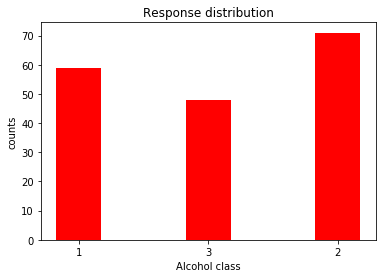

In [46]:
# Checking if the responses are skewed or not

from matplotlib import pyplot as plt
%matplotlib inline
 
responses = df.groupBy('Alcohol').count().collect()
categories = [i[0] for i in responses]
counts = [i[1] for i in responses]
 
index = np.array(range(len(categories)))
plt.bar(index, counts, width=0.35, color='r')
 
plt.ylabel('counts')
plt.xlabel('Alcohol class')
plt.title('Response distribution')
plt.xticks(index , categories)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


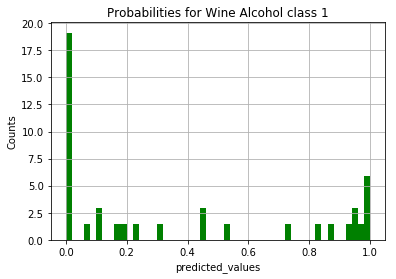

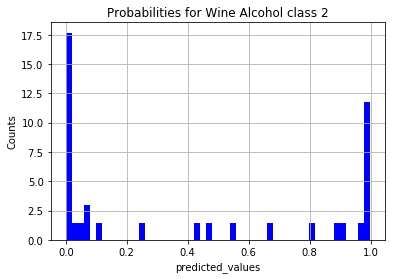

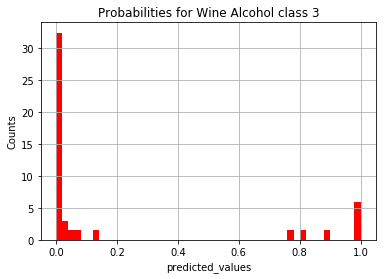

In [47]:
# Plotting prediction probabilities for all 3 classes

all_probs = transformed.select("probability").collect()
alc1_probs = [i[0][0] for i in all_probs]
alc2_probs = [i[0][1] for i in all_probs]
alc3_probs = [i[0][2] for i in all_probs]
 
from matplotlib import pyplot as plt
%matplotlib inline
 
# 1
plt.hist(alc1_probs, 50, normed=1, facecolor='green')
plt.xlabel('predicted_values')
plt.ylabel('Counts')
plt.title('Probabilities for Wine Alcohol class 1')
plt.grid(True)
plt.show()
 
# 2
plt.hist(alc2_probs, 50, normed=1, facecolor='blue')
plt.xlabel('predicted_values')
plt.ylabel('Counts')
plt.title('Probabilities for Wine Alcohol class 2')
plt.grid(True)
plt.show()

# 3
plt.hist(alc3_probs, 50, normed=1, facecolor='red')
plt.xlabel('predicted_values')
plt.ylabel('Counts')
plt.title('Probabilities for Wine Alcohol class 3')
plt.grid(True)
plt.show()